In [1]:
from datasets import load_dataset

In [2]:
ds = load_dataset("distilabel-internal-testing/critique-bench-gpt-4-turbo-v0.1")

Generating train split:   0%|          | 0/3641 [00:00<?, ? examples/s]

In [5]:
df = ds["train"].to_pandas()

In [17]:
print("Number of rows:")
len(df)

Number of rows:


3641

In [14]:
print("Number of rows wrongly parsed:")
len(df[df["raw_output"].notna()])

Number of rows wrongly parsed:


111

In [18]:
df_bad = df[df["raw_output"].notna()]

In [ ]:
# Ways to split score/critique
# .split("Feedback Score:") -> **Feedback Score: [7] (Very Good)**
# **Feedback:** [7] (Very Good)
# **Feedback Score: 3 [Moderate Quality]** -> And more text
# Feedback: [7] (Very Good)
# Score: 7 [Very Good] -> and more text
# **Feedback Score:** [10] (Excellent)

In [33]:
df_bad["raw_output"].sample().iloc[0]

"The response accurately categorizes Inc. magazine under **Business News**, which aligns perfectly with the content typically covered by the magazine such as entrepreneurship, small business, and startup culture. The detailed explanation of the topics covered by Inc. magazine enhances the informativeness of the response, providing a clear understanding of why it fits into the Business News category.\n\nThe response confidently conveys the information without expressing unnecessary uncertainty, which is appropriate given the clear alignment of the magazine's content with the Business News category. There is no evidence of hallucination or misleading details in the response; all mentioned topics are genuinely covered by Inc. magazine, demonstrating truthfulness.\n\nFurthermore, the response follows the instruction well by categorizing the magazine based on its content and then explaining why it fits into that category, aligning with the user's intent.\n\nOverall, the response meets all t

## Create the dataset in argilla for curation of these examples

In [46]:
initial_ds = load_dataset("distilabel-internal-testing/prometheus-bench-critique")

Generating test split:   0%|          | 0/3641 [00:00<?, ? examples/s]

In [49]:
initial_df = initial_ds["test"].to_pandas()

In [71]:
#print((initial_df["instruction"] + "\n---\n" + initial_df["response"])[0])
df_non_duplicates = initial_df.loc[(initial_df["instruction"] + "\n---\n" + initial_df["response"]).drop_duplicates().index]

In [73]:
df_non_duplicates["base_dataset"].value_counts()

base_dataset
feedback_eval    1000
flask_eval        669
mt_bench_eval     320
vicuna_eval       320
Name: count, dtype: int64

In [78]:
new_df = df_non_duplicates.reset_index().drop(columns="index")

In [80]:
import hashlib

In [85]:
new_df["hashid"] = (new_df["instruction"] + new_df["response"]).apply(lambda x: hashlib.sha256(x.encode("utf-8")).hexdigest())

In [88]:
new_df.head(2)

,idx,response_source,category,instruction,base_dataset,criteria,response,hashid
0,81,chatgpt,writing,Here is a previous dialogue between an assista...,mt_bench_eval,None,Aloha! Allow me to take you on an incredible j...,8bb606d0e023413a4574ff34dfb4f4bb696f6076b847a6...
1,81,vicuna_13b,writing,Here is a previous dialogue between an assista...,mt_bench_eval,None,"Ahoy from Hawaii!\n\nA little while back, I wa...",47098c70a73d0a386bd8302f5eb064439a08be53165894...


In [92]:
from datasets import Dataset

col_order = ["idx", "hashid", "response_source", "category", "criteria", "base_dataset", "instruction", "response"]

ds = Dataset.from_pandas(new_df[col_order], preserve_index=False)
ds

Dataset({
    features: ['idx', 'hashid', 'response_source', 'category', 'criteria', 'base_dataset', 'instruction', 'response'],
    num_rows: 2309
})

In [107]:
import json
#print(json.dumps(ds[0], indent=2))

In [95]:
#ds.push_to_hub("distilabel-internal-testing/prometheus-bench-critique", split="test")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/8.92k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/distilabel-internal-testing/prometheus-bench-critique/commit/f203971ca50678b201391ff96f147be29b21cc8c', commit_message='Upload dataset', commit_description='', oid='f203971ca50678b201391ff96f147be29b21cc8c', pr_url=None, pr_revision=None, pr_num=None)

### Clean up already generated datasets

In [99]:
# Prometheus
gpt4_turbo_ds = "distilabel-internal-testing/critique-bench-gpt-4-turbo-v0.1"

base_name = "distilabel-internal-testing/critique-bench-prometheus-temperature{temp}-v0.1"
prometheus_ds = [base_name.format(temp=t) for t in [0.1, 0.3, 0.5, 0.7, 1]]

base_name = "distilabel-internal-testing/critique-bench-criticon-sft-temperature{temp}-v0.1"
criticon_ds = [base_name.format(temp=t) for t in [0.1, 0.3, 0.5, 0.7, 1]]

In [118]:
test_ds = load_dataset("distilabel-internal-testing/critique-bench-criticon-sft-temperature0.3-v0.1")

Generating train split:   0%|          | 0/2309 [00:00<?, ? examples/s]

### Cleanup of labelled datasets

In [ ]:
import os

col_order = ["idx", "hashid", "response_source", "category", "criteria", "base_dataset", "instruction", "response", "model_name", "score", "critique", "raw_output"]

#for ds_name in [gpt4_turbo_ds]:
#for ds_name in criticon_ds:
#for ds_name in prometheus_ds:
    print(f"Cleaning: {ds_name}") 
    old_ds = load_dataset(ds_name, split="train", token=os.getenv("HF_API_TOKEN"))
    
    old_df = old_ds.to_pandas()
    
    df = old_df.loc[(old_df["instruction"] + "\n" + old_df["response"]).drop_duplicates().index]
    df = df.reset_index().drop(columns="index")
    
    # Add a hash id using instruction + response
    df["hashid"] = (df["instruction"] + df["response"]).apply(lambda x: hashlib.sha256(x.encode("utf-8")).hexdigest())
    
    # Reorder the columns and back to a Dataset
    ds = Dataset.from_pandas(df[col_order], preserve_index=False)

    ds.push_to_hub(ds_name, split="train", private=True, token=os.getenv("HF_API_TOKEN"))

In [122]:
#print(json.dumps(ds[0], indent=2))

In [123]:
ds = load_dataset(gpt4_turbo_ds, split="train", token=os.getenv("HF_API_TOKEN"))

Generating train split:   0%|          | 0/2309 [00:00<?, ? examples/s]

In [125]:
df = ds.to_pandas()

In [204]:
df_bad = df[df["raw_output"].notna()]["raw_output"]
# Split on the score
df_bad = df_bad.str.split("Score: ").apply(lambda x: x[-1].strip())
# Grab the first digit if at all
df_bad = df_bad.apply(lambda x: x[0] if x[0].isdigit() else x)
# Grab a number between [] or ()
def f(x):
    if len(x) > 2:
        if x[1:3].isdigit():
            return x[1:3]
        if x[1].isdigit():
            return x[1]
    return x

df_bad = df_bad.apply(f)
# Then we have the ones that didn't obey the initial split
df_bad


3                                                       7
74                                                      7
127                                                     7
167                                                     7
209                                                     5
                              ...                        
2188    The response provided is generally informative...
2226                                                    7
2268                                                    3
2274                                                    7
2305                                                    7
Name: raw_output, Length: 61, dtype: object

In [207]:
df_bad[df_bad.str.len() > 1].sample().iloc[0]

'The response successfully delivers a haiku in Japanese along with an English translation, adhering to the traditional 5-7-5 syllable structure. The translation is accurate and captures the essence of the original poem, ensuring that the information provided is both correct and informative. The explanation of the poem\'s meaning and theme is clear and enhances the reader\'s understanding, aligning well with the instruction to explain these aspects.\n\nThe response confidently presents the haiku and its translation without expressing unnecessary uncertainty, which is appropriate given the straightforward nature of the task. There is no evidence of hallucination or misleading information in the translation or the explanation of the poem.\n\nFurthermore, the response excellently follows the given instruction by not only providing the haiku and its translation but also by explaining the meaning and theme as requested. The mention of the "kigo" and its significance in setting the atmosphere

In [163]:
print(df[df["raw_output"].notna()]["raw_output"].sample().iloc[0])

The response does not provide the requested code completion, which directly impacts its correctness and informativeness. The user asked for a completion of a specific code snippet, but the response sidesteps this by asking for more information instead of attempting to address the task. This shows a lack of instruction following, as the model does not align with the user's intent to have the code completed in the response.

Regarding honesty and uncertainty, the response appropriately indicates a need for more information to proceed effectively, which is a good practice in scenarios where the model might not have enough context. However, this should not substitute for an attempt to address the given task when the task is clear.

There are no issues with truthfulness and hallucination in this response, as it does not introduce any misleading or fabricated details—it simply does not provide the requested service.

Overall, the response fails primarily on the fronts of correctness, informa

In [750]:
import argilla as rg
id_ = "id"
instruction = "instruction"
response = "response"
idx = 0

argilla_space = "https://plaguss-clean-bench.hf.space"

rg_dataset = rg.FeedbackDataset(
    fields=[
        rg.TextField(name=id_, title=id_),
        rg.TextField(name=instruction, title=instruction, use_markdown=True),
        rg.TextField(name=response, title=response, use_markdown=True),
    ],
    questions=[
        rg.RatingQuestion(  # type: ignore
            name="score",
            title=f"Rate {response} given {instruction} based on the annotation guidelines.",
            description=f"Ignore this question if the corresponding `{response}` field is not available."
            if idx != 0
            else None,
            values=list(range(1,11)),
            required=True if idx == 0 else False,
        ),
        rg.TextQuestion(  # type: ignore
            name="critique",
            title=f"Specify the critique for {response}'s score.",
            description=f"Ignore this question if the corresponding `{response}` field is not available."
            if idx != 0
            else None,
            required=False,
        ),
    ],
)


#rg_dataset.add_vector_settings(
#    rg.VectorSettings(name="instruction_vector", dimensions=384)
#)
#rg_dataset.add_vector_settings(
#    rg.VectorSettings(name="response_vector", dimensions=384)
#)
#rg_dataset.add_vector_settings(
#    rg.VectorSettings(name="critique_vector", dimensions=384)
#)

In [751]:
from typing import Dict, Any, List

rating = "score"
rationale = "critique"
raw_output = "raw_output"

def add_suggestions_if_any(input: Dict[str, Any]) -> List["SuggestionSchema"]:
    """Method to generate the suggestions for the `FeedbackRecord` based on the input."""
    # Since the `suggestions` i.e. answers to the `questions` are optional, will default to {}
    suggestions = []
    # If `ratings` is in `input`, then add those as suggestions
    if rating in input:
        try:
            suggestions.extend(
                [
                    {
                        "question_name": rating,
                        "value": int(float(score)),
                    }
                    for idx, score in enumerate([input[rating]])
                    if score is not None
                ],
            )

        except:
            pass
    # If `rationales` is in `input`, then add those as suggestions
    if rationale in input:
        suggestions.extend(
            [
                {
                    "question_name": rationale,
                    "value": r,
                }
                for idx, r in enumerate([input[rationale]])
                if r is not None and isinstance(r, str)
            ],
        )
    if raw_output in input:
        # If neither score/critique were found, we should have the raw_output, and we can
        # use it to write in the critique and clean it up afterwards.
        suggestions.extend(
            [
                {
                    "question_name": rationale,
                    "value": r,
                }
                for idx, r in enumerate([input[raw_output]])
                if r is not None and isinstance(r, str)
            ],
        )
    return suggestions

In [752]:
from typing import Dict, Optional, Any


def build_record(input: Dict[str, Any]) -> rg.FeedbackRecord:
    return rg.FeedbackRecord(
        fields={
            "id": input["hashid"],
            "instruction": input["instruction"],
            "response": input["response"]
        },
        suggestions=add_suggestions_if_any(input),
        #vectors=vectors,
    )

In [753]:
cols = ["hashid", "instruction", "response", "score", "critique", "raw_output"]
#ds_test = Dataset.from_pandas(df[cols].sample(5, random_state=42), preserve_index=False)
ds_test = Dataset.from_pandas(df, preserve_index=False)

records = []
for input in ds_test:
    records.append(build_record(input))

rg_dataset.add_records(records)

In [708]:
#rg_dataset.records[0]

In [754]:
rg_dataset_name = "critique-bench-gpt-4-turbo"

In [755]:
rg_dataset.push_to_argilla(name=rg_dataset_name, workspace="admin")

Output()

[04/17/24 12:17:00] INFO     INFO:argilla.client.feedback.dataset.local.mixins:✓ Dataset succesfully  ]8;id=172918;file:///Users/agus/github_repos/argilla-io/distilabel-workbench/.venv/lib/python3.10/site-packages/argilla/client/feedback/dataset/local/mixins.py\mixins.py]8;;\:]8;id=78704;file:///Users/agus/github_repos/argilla-io/distilabel-workbench/.venv/lib/python3.10/site-packages/argilla/client/feedback/dataset/local/mixins.py#281\281]8;;\
                             pushed to Argilla                                                                     

                    INFO     INFO:argilla.client.feedback.dataset.local.mixins:RemoteFeedbackDataset( ]8;id=38376;file:///Users/agus/github_repos/argilla-io/distilabel-workbench/.venv/lib/python3.10/site-packages/argilla/client/feedback/dataset/local/mixins.py\mixins.py]8;;\:]8;id=135595;file:///Users/agus/github_repos/argilla-io/distilabel-workbench/.venv/lib/python3.10/site-packages/argilla/client/feedback/dataset/local/mixins.py#282\282]8;;\
                                id=54611baa-44a8-4c9c-b3fa-9274e82ae0d8                                            
                                name=critique-bench-gpt-4-turbo                                                    
                                workspace=Workspace(id=693e7961-eacd-4358-93dd-173fb7efa108,                       
                             name=admin, inserted_at=2024-04-16 11:37:37.228346,                                   
                             updated_at=2024-04-16 11:37:37.228346)                                                
                                url=https://plaguss-clean-bench.hf.space/dataset/54611baa-44a8-4c9c-b              
                             3fa-9274e82ae0d8/annotation-mode                                                      
                                fields=[RemoteTextField(id=UUID('8ae5da2e-b5e2-41a5-9c33-5f4a2e644d40              
                             '), client=None, name='id', title='id', required=True, type='text',                   
                             use_markdown=False),                                                                  
                             RemoteTextField(id=UUID('8fc9e094-c211-44da-bc2e-1d0edea3c8f5'),                      
                             client=None, name='instruction', title='instruction', required=True,                  
                             type='text', use_markdown=True),                                                      
                             RemoteTextField(id=UUID('ea3563a7-222a-4091-8925-dc720c9b1703'),                      
                             client=None, name='response', title='response', required=True,                        
                             type='text', use_markdown=True)]                                                      
                                questions=[RemoteRatingQuestion(id=UUID('db952e79-743e-4dbc-bf8c-d5f1              
                             a10cd2a5'), client=None, name='score', title='Rate response given                     
                             instruction based on the annotation guidelines.', description=None,                   
                             required=True, type='rating', values=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),                
                             RemoteTextQuestion(id=UUID('d889ac0c-6c3c-44b5-8d72-731ce54be208'),                   
                             client=None, name='critique', title="Specify the critique for response's              
                             score.", description=None, required=False, type='text',                               
                             use_markdown=False)]                                                                  
                                guidelines=None                                                                    
                                metadata_properties=[]                                                             
                                vectors_settings=[]                                                                
                             )                                                                                     

RemoteFeedbackDataset(
   id=54611baa-44a8-4c9c-b3fa-9274e82ae0d8
   name=critique-bench-gpt-4-turbo
   workspace=Workspace(id=693e7961-eacd-4358-93dd-173fb7efa108, name=admin, inserted_at=2024-04-16 11:37:37.228346, updated_at=2024-04-16 11:37:37.228346)
   url=https://plaguss-clean-bench.hf.space/dataset/54611baa-44a8-4c9c-b3fa-9274e82ae0d8/annotation-mode
   fields=[RemoteTextField(id=UUID('8ae5da2e-b5e2-41a5-9c33-5f4a2e644d40'), client=None, name='id', title='id', required=True, type='text', use_markdown=False), RemoteTextField(id=UUID('8fc9e094-c211-44da-bc2e-1d0edea3c8f5'), client=None, name='instruction', title='instruction', required=True, type='text', use_markdown=True), RemoteTextField(id=UUID('ea3563a7-222a-4091-8925-dc720c9b1703'), client=None, name='response', title='response', required=True, type='text', use_markdown=True)]
   questions=[RemoteRatingQuestion(id=UUID('db952e79-743e-4dbc-bf8c-d5f1a10cd2a5'), client=None, name='score', title='Rate response given instruction 

In [393]:
import argilla as rg

rg.init(
    api_url="https://plaguss-clean-bench.hf.space",
    api_key="admin.apikey"
    # extra_headers={"Authorization": f"Bearer {"HF_TOKEN"}"}
)

/Users/agus/github_repos/argilla-io/distilabel-workbench/.venv/lib/python3.10/site-packages/argilla/client/client.py:178: UserWarning: No workspace configuration was detected. To work with Argilla datasets, specify a valid workspace name on `rg.init` or set it up through the `rg.set_workspace` function.
  warnings.warn(
/Users/agus/github_repos/argilla-io/distilabel-workbench/.venv/lib/python3.10/site-packages/argilla/client/client.py:195: UserWarning: You're connecting to Argilla Server 1.26.1 using a different client version (1.24.0).
This may lead to potential compatibility issues during your experience.
To ensure a seamless and optimized connection, we highly recommend aligning your client version with the server version.
  warnings.warn(


In [540]:
df_.columns

Index(['idx', 'hashid', 'response_source', 'category', 'criteria',
       'base_dataset', 'instruction', 'response', 'model_name', 'score',
       'critique', 'raw_output'],
      dtype='object')

In [668]:
df = df.set_index("hashid")

In [671]:
#df_criticon.loc[df_cleaned.index]

In [674]:
dfs_criticon = []

keep_cols = ['hashid', 'instruction', 'response', 'score', 'critique']

for temp, ds_name in zip([0.1, 0.3, 0.5, 0.7, 1], criticon_ds):
    print(ds_name)
    ds_criticon = load_dataset(ds_name, split="train", token=os.getenv("HF_API_TOKEN"))
    df_ = ds_criticon.to_pandas().set_index("hashid")
    df_ = df_.loc[df.index]
    dfs_criticon.append(df_)
    

distilabel-internal-testing/critique-bench-criticon-sft-temperature0.1-v0.1
distilabel-internal-testing/critique-bench-criticon-sft-temperature0.3-v0.1
distilabel-internal-testing/critique-bench-criticon-sft-temperature0.5-v0.1
distilabel-internal-testing/critique-bench-criticon-sft-temperature0.7-v0.1
distilabel-internal-testing/critique-bench-criticon-sft-temperature1-v0.1


In [675]:
scores_criticon = []
for temp, df_i in zip([0.1, 0.3, 0.5, 0.7, 1], dfs_criticon):
    scores_criticon.append(df_i["score"].astype(float).rename(f"criticon-score-temp-{temp}"))
#    scores_criticon.append(df_i[f"score-temp-{temp}"].astype(float).rename(f"criticon-score-temp-{temp}"))
pd.concat(scores_criticon, axis=1).corr("pearson")

,criticon-score-temp-0.1,criticon-score-temp-0.3,criticon-score-temp-0.5,criticon-score-temp-0.7,criticon-score-temp-1
criticon-score-temp-0.1,1.000000,0.875409,0.851392,0.827795,0.781910
criticon-score-temp-0.3,0.875409,1.000000,0.839129,0.831030,0.789701
criticon-score-temp-0.5,0.851392,0.839129,1.000000,0.815332,0.788265
criticon-score-temp-0.7,0.827795,0.831030,0.815332,1.000000,0.762391
criticon-score-temp-1,0.781910,0.789701,0.788265,0.762391,1.000000


In [677]:
dfs_prometheus = []
keep_cols = ['hashid', 'instruction', 'response', 'score', 'critique']

for temp, ds_name in zip([0.1, 0.3, 0.5, 0.7, 1], prometheus_ds):
    ds_prometheus = load_dataset(ds_name, split="train", token=os.getenv("HF_API_TOKEN"))
    print(ds_name)
    df_ = ds_prometheus.to_pandas()
    df_ = df_.set_index("hashid")
    df_ = df_.loc[df.index]

    dfs_prometheus.append(df_)

distilabel-internal-testing/critique-bench-prometheus-temperature0.1-v0.1
distilabel-internal-testing/critique-bench-prometheus-temperature0.3-v0.1
distilabel-internal-testing/critique-bench-prometheus-temperature0.5-v0.1
distilabel-internal-testing/critique-bench-prometheus-temperature0.7-v0.1
distilabel-internal-testing/critique-bench-prometheus-temperature1-v0.1


In [678]:
scores_prometheus = []
for temp, df_i in zip([0.1, 0.3, 0.5, 0.7, 1], dfs_prometheus):
#    scores_prometheus.append(df_i[f"score-temp-{temp}"].astype(float).rename(f"prometheus-score-temp-{temp}"))
    scores_prometheus.append(df_i["score"].astype(float).rename(f"prometheus-score-temp-{temp}"))
pd.concat(scores_prometheus, axis=1).corr("pearson")

,prometheus-score-temp-0.1,prometheus-score-temp-0.3,prometheus-score-temp-0.5,prometheus-score-temp-0.7,prometheus-score-temp-1
prometheus-score-temp-0.1,1.000000,0.901875,0.864132,0.834570,0.809293
prometheus-score-temp-0.3,0.901875,1.000000,0.855781,0.828182,0.799053
prometheus-score-temp-0.5,0.864132,0.855781,1.000000,0.814506,0.795638
prometheus-score-temp-0.7,0.834570,0.828182,0.814506,1.000000,0.774163
prometheus-score-temp-1,0.809293,0.799053,0.795638,0.774163,1.000000


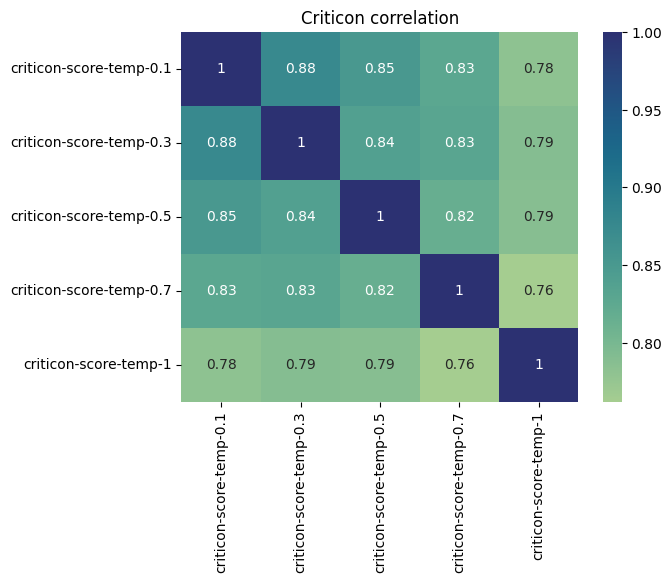

In [679]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(pd.concat(scores_criticon, axis=1).corr("pearson"), annot=True, cmap="crest");
plt.title("Criticon correlation");


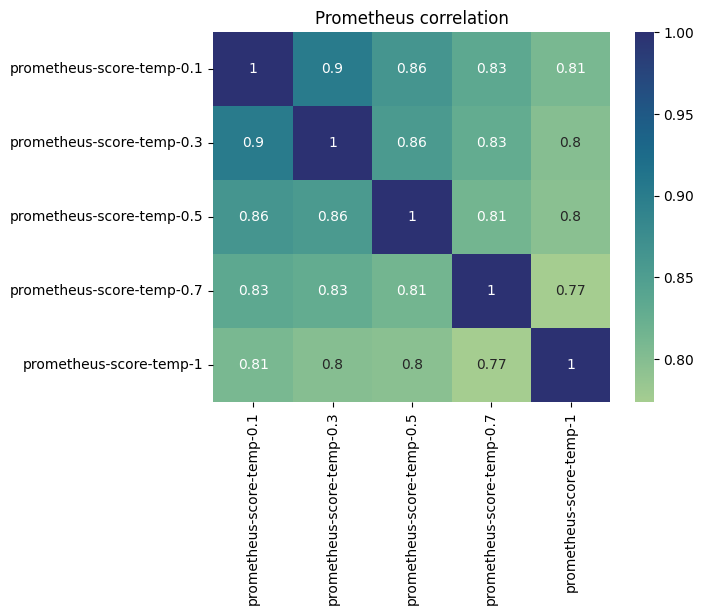

In [680]:
sns.heatmap(pd.concat(scores_prometheus, axis=1).corr("pearson"), annot=True, cmap="crest");
plt.title("Prometheus correlation");

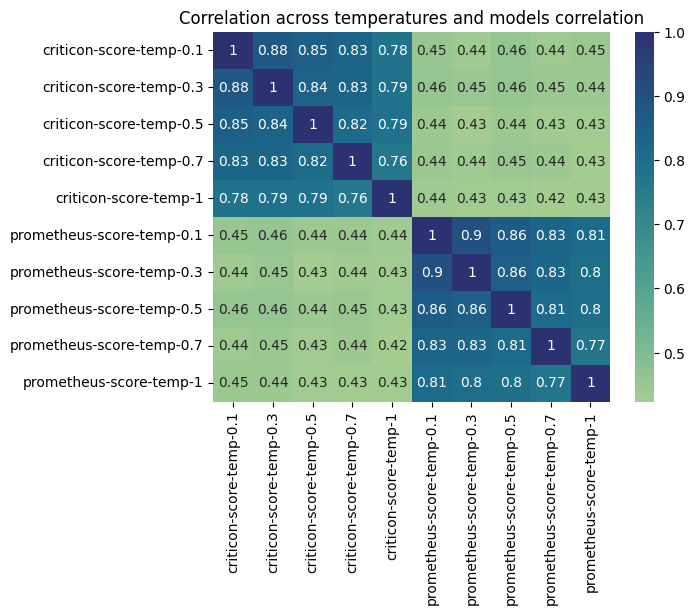

In [681]:
sns.heatmap(
    pd.concat([pd.concat(scores_criticon, axis=1), pd.concat(scores_prometheus, axis=1)*2], axis=1).corr("pearson")
, annot=True, cmap="crest");
plt.title("Correlation across temperatures and models correlation");

In [282]:
#!pip install seaborn

In [682]:
df = ds.to_pandas()
df_cleaned = df[~df["raw_output"].notna()]
# just get the score fast
def f(x):
    # common correct case
    if x.isdigit():
        return x
    # Examples like '10"'
    if x[:2].isdigit():
        return x[:2]
    # '3**', '7 (Very Good)' or any single digit with something extra
    if x[0].isdigit():
        return x[0]

df_cleaned["score"] = df_cleaned["score"].apply(f)
#df_cleaned = df_cleaned.sort_values("hashid")
df_cleaned = df_cleaned.set_index("hashid")

df_criticon = ds_criticon.to_pandas()
df_criticon = df_criticon.set_index("hashid")
df_criticon = df_criticon.loc[df_cleaned.index].sort_values("hashid")

df_prometheus = ds_prometheus.to_pandas()
df_prometheus = df_prometheus.set_index("hashid")
df_prometheus = df_prometheus.loc[df_cleaned.index].sort_values("hashid")
#keep_cols = ["hashid", "instruction", "response", "score", "critique"]
#df_cleaned = df_cleaned[keep_cols].merge(df_criticon[keep_cols], left_on="hashid", right_on="hashid")[["score_x"]].rename(columns={"score_x": "score"})



/var/folders/q6/mm81p31j6y3f2ndyvv11_3vh0000gn/T/ipykernel_28302/1794307593.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["score"] = df_cleaned["score"].apply(f)


In [629]:
df_criticon["hashid"]#.loc[df_cleaned["hashid"].iloc[0]]
#df_cleaned["hashid"]
keep_cols = ["hashid", "instruction", "response", "score", "critique"]
dfs_criticon[4][keep_cols].merge(df_cleaned[keep_cols], left_on="hashid", right_on="hashid")[["score_x", "score_y"]].corr()

,score_x,score_y
score_x,1.000000,0.572504
score_y,0.572504,1.000000


In [655]:
df_criticon[df_criticon["hashid"] == df_cleaned["hashid"].iloc[1]]

,idx,hashid,response_source,category,criteria,base_dataset,instruction,response,model_name,score,critique,raw_output
2220,182,000924ffe3ddc1f606778cecce7c80dda1b47cb0b7fa84...,None,None,None,feedback_eval,"A user is planning a trip to San Francisco, Ca...",San Francisco is a wonderful place to visit wi...,distilabel-internal-testing/criticon-sft-v0.1,7,Your answer is comprehensive and covers most o...,None


In [683]:
import pandas as pd
indices = df_cleaned.sort_values("hashid").index

df_all = pd.DataFrame(
    {
        "score-gpt4-turbo": df_cleaned.sort_values("hashid")["score"],
        "score-criticon": df_criticon.loc[indices]["score"],
        "score-prometheus": df_prometheus.sort_values("hashid")["score"].astype(float)*2}
)
df_all.corr()

,score-gpt4-turbo,score-criticon,score-prometheus
score-gpt4-turbo,1.000000,0.572504,0.439524
score-criticon,0.572504,1.000000,0.428576
score-prometheus,0.439524,0.428576,1.000000


#### Merging all the models

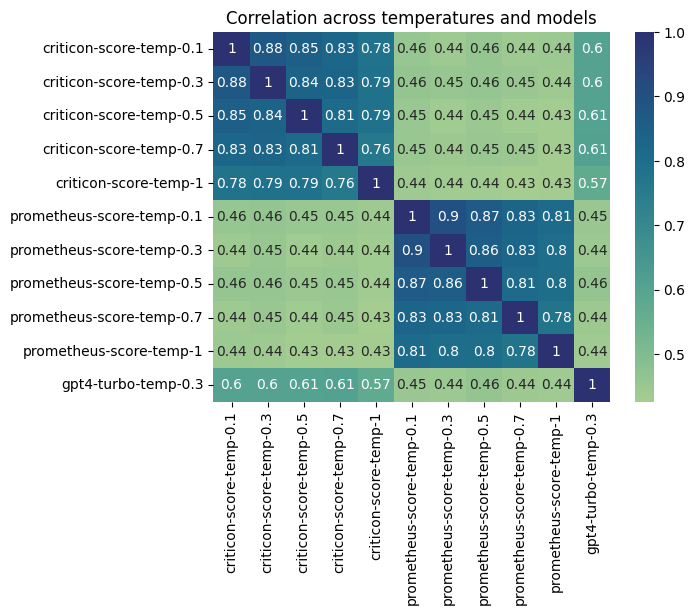

In [684]:
scores_criticon_all = pd.concat(scores_criticon, axis=1)
scores_criticon_all = scores_criticon_all.loc[df_cleaned.index]

scores_prometheus_all = pd.concat(scores_prometheus, axis=1)*2
scores_prometheus_all = scores_prometheus_all.loc[df_cleaned.index]

df_all_cleaned = pd.concat([scores_criticon_all, scores_prometheus_all], axis=1)

df_all_cleaned["gpt4-turbo-temp-0.3"] = df_cleaned["score"].astype(float)

sns.heatmap(df_all_cleaned.corr("pearson"), annot=True, cmap="crest");
plt.title("Correlation across temperatures and models");

In [686]:
cosa

,criticon-score-temp-1,gpt4-turbo-temp-0.3,ones
hashid,,,
92add514173eab039a3fce6a0dd8f713acc63a834f7c8735a9e8abf4d1f4da46,6.0,7.0,1
03cbffd41f76f9512aa9b09c95958b3b5c24cf90a64d11867081e24be437787f,7.0,9.0,1
6a71c472dff8333433662a820c13572420a439a8dde2ce157c4a092cf292a339,7.0,1.0,1
70e8ef561115c4c82c65422eacdda627d311876e567ccda130223efd24af106e,8.0,10.0,1
dd29aa4c37b760afb24f21b34931d04d167d505b9f91a20146e6ac9194214c4e,8.0,5.0,1
...,...,...,...
875f0274cdcd8a67219e0724d18899e6d4a32f893c379dd4b52ff32af32c0e2e,8.0,10.0,1
530755cf29efb30609e6f7d5c96169e6fcd3e1cd58aa63776b7a2f0977c3ebc3,8.0,7.0,1
ead90b410a1a8f6868f18b03c2708dd5a33930a8cbedae3813dc139f8af54c2c,8.0,10.0,1


In [702]:
table = pd.pivot_table(cosa, index=x_col, columns=y_col, values="ones", aggfunc="count")
table.sort_values("criticon-score-temp-1")
#table

gpt4-turbo-temp-0.3,1.0,3.0,5.0,7.0,8.0,9.0,10.0
criticon-score-temp-1,,,,,,,
1.0,3.0,NaN,NaN,1.0,NaN,NaN,NaN
2.0,23.0,6.0,NaN,1.0,NaN,NaN,4.0
3.0,55.0,27.0,3.0,5.0,NaN,NaN,13.0
4.0,26.0,42.0,6.0,7.0,NaN,1.0,11.0
5.0,19.0,22.0,19.0,9.0,NaN,NaN,7.0
6.0,24.0,72.0,73.0,116.0,3.0,6.0,61.0
7.0,10.0,29.0,49.0,182.0,6.0,25.0,166.0
8.0,13.0,40.0,40.0,384.0,10.0,85.0,502.0
9.0,1.0,4.0,NaN,12.0,1.0,1.0,21.0


In [704]:
table

gpt4-turbo-temp-0.3,1.0,3.0,5.0,7.0,8.0,9.0,10.0
criticon-score-temp-1,,,,,,,
1.0,3.0,NaN,NaN,1.0,NaN,NaN,NaN
2.0,23.0,6.0,NaN,1.0,NaN,NaN,4.0
3.0,55.0,27.0,3.0,5.0,NaN,NaN,13.0
4.0,26.0,42.0,6.0,7.0,NaN,1.0,11.0
5.0,19.0,22.0,19.0,9.0,NaN,NaN,7.0
6.0,24.0,72.0,73.0,116.0,3.0,6.0,61.0
7.0,10.0,29.0,49.0,182.0,6.0,25.0,166.0
8.0,13.0,40.0,40.0,384.0,10.0,85.0,502.0
9.0,1.0,4.0,NaN,12.0,1.0,1.0,21.0


/var/folders/q6/mm81p31j6y3f2ndyvv11_3vh0000gn/T/ipykernel_28302/1642324280.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cosa["ones"] = 1


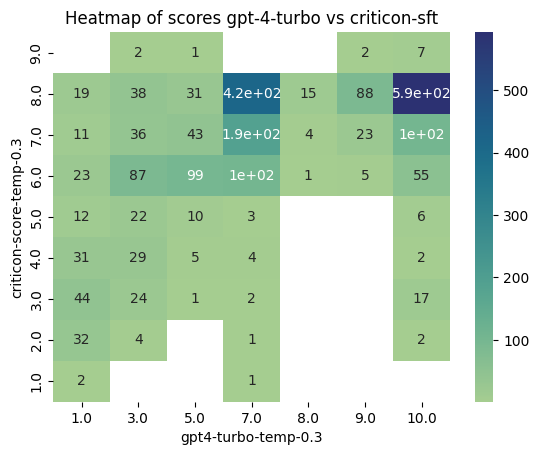

In [707]:
x_col = "criticon-score-temp-0.3"
y_col = "gpt4-turbo-temp-0.3"
cosa = df_all_cleaned[[x_col, y_col]]
cosa["ones"] = 1
table = pd.pivot_table(cosa, index=x_col, columns=y_col, values="ones", aggfunc="count")
table = table.sort_values(x_col, ascending=False)
sns.heatmap(table, annot=True, cmap="crest");
plt.title("Heatmap of scores gpt-4-turbo vs criticon-sft");

In [385]:
pivot_tab = pd.pivot_table(cosa, index="criticon-score-temp-1", columns="gpt4-turbo-temp-0.3", values="ones", aggfunc="count")
pivot_tab

gpt4-turbo-temp-0.3,1.0,3.0,5.0,7.0,9.0,10.0
criticon-score-temp-1,,,,,,
2.0,NaN,NaN,NaN,1.0,NaN,3.0
3.0,NaN,2.0,NaN,5.0,NaN,16.0
4.0,NaN,NaN,NaN,5.0,3.0,8.0
5.0,NaN,NaN,2.0,3.0,1.0,11.0
6.0,NaN,3.0,5.0,17.0,6.0,27.0
7.0,1.0,6.0,3.0,18.0,5.0,25.0
8.0,NaN,8.0,5.0,42.0,13.0,63.0
9.0,NaN,NaN,NaN,NaN,NaN,4.0
